In [1]:
import numpy as np
from matplotlib import pyplot as plt
from MRK4 import *

# Standard CG + discrete upwinding + FCT

min, max value of (FCT solution)= 0.0 1.0
loss in mass with FCT solution= 1.6069017461679896e-14


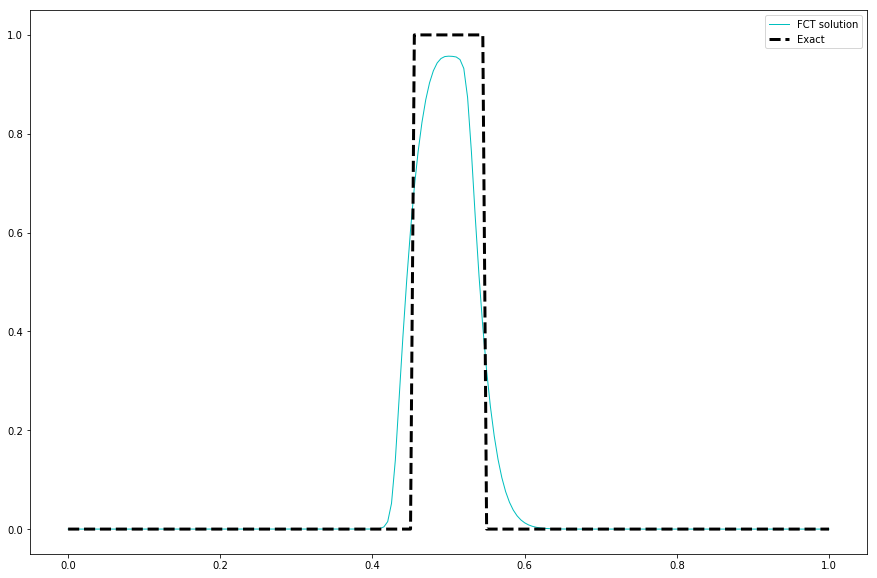

In [2]:
N=201

USE_FCT=True
global_bounds=False

# physical parameters #
U=1
T=1.0
DT=0.1
x=np.linspace(0,1,N)

# Numerical parameters #
h=1./(N-1);
C=0.75
dt=C*h*U

# Initial conditions #
u0=1.0*(x>0.45)*(x<0.55)
#u0=0.5*(x>0.4)*(x<0.45)+1.0*(x>=0.45)*(x<=0.55)+0.5*(x>0.55)*(x<0.6)
un=1.0*u0;

(D1,DL)=compute_matrices(U,N)
initial_mass=h*np.sum(u0)

# Time loop #
NT=T/dt
times = np.linspace(0,T,int(NT)+1)
uu = np.zeros([len(u0),int(NT)+1])
i=0
for t in times:
    # First stage #
    f,fG,fB,fijG,fijB=sdisc(un,D1,DL) # spatial discretization
    sf,_ = limited_conservative_flux(un,un+dt*fG,dt*fijB,global_bounds=global_bounds) # limit anti-diffusive fluxes 
    sf/=dt
    u1 = un + dt*(fG + (sf if USE_FCT else fB))
    
    # Second stage 
    f,fG,fB,fijG,fijB=sdisc(u1,D1,DL)
    sf,_ = limited_conservative_flux(u1,u1+dt*fG,dt*fijB,global_bounds=global_bounds)
    sf/=dt
    u2 = 3./4*un + 1./4*(u1 + dt*(fG + (sf if USE_FCT else fB)))
    
    # Third stage
    f,fG,fB,fijG,fijB=sdisc(u2,D1,DL)
    sf,_ = limited_conservative_flux(u2,u2+dt*fG,dt*fijB,global_bounds=global_bounds)
    sf/=dt
    u3 = 1./3*un + 2./3*(u2 + dt*(fG + (sf if USE_FCT else fB)))

    # update solution at new time step
    unp1 = u3
    
    # update old solution 
    un = unp1

    # save solution for animation 
    uu[:,i] = unp1
    i+=1
#
loss = (initial_mass - h*np.sum(unp1))/initial_mass

print('min, max value of (FCT solution)=',np.min(uu),np.max(uu))
print('loss in mass with FCT solution=',loss)

# plot final solutions #
plt.figure(figsize=([15,10]))
plt.plot(x,unp1,'-c',linewidth=1)
plt.plot(x,u0,'--k',linewidth=3)
plt.legend(['FCT solution','Exact'])
plt.show()

# Modified RK4 with limiting on last stage

min,max with RK4= -0.4838176717344239 1.3766023321077228
min,max with MRK4= -3.686287386450715e-18 1.0
loss in mass with RK4 and MRK4= -4.382459307730881e-16 0.0


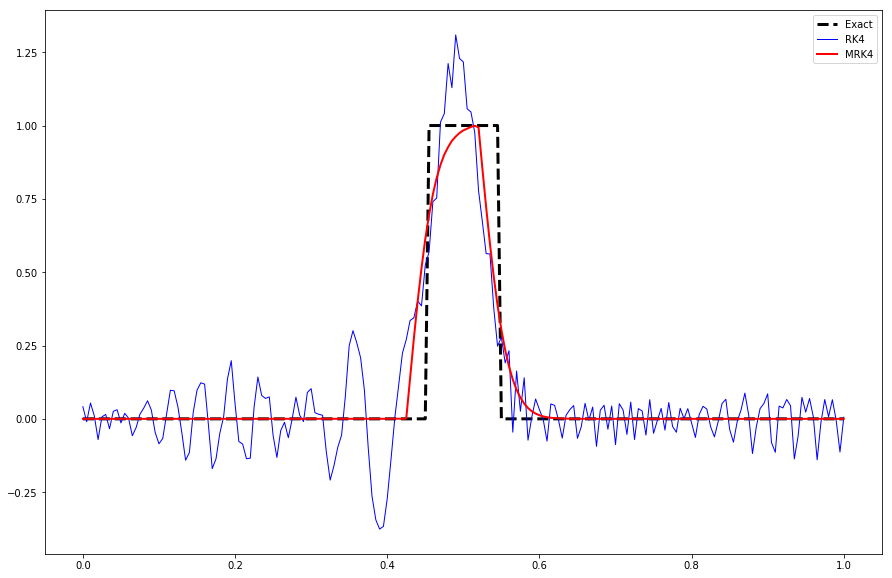

In [5]:
N=201

global_bounds=False
single_gamma=False
conservative=True

# physical parameters #
U=1
T=1.0
DT=0.1
x=np.linspace(0,1,N)

# Numerical parameters #
h=1./(N-1);
C=0.75
dt=C*h*U

# Initial conditions #
u0=1.0*(x>0.45)*(x<0.55)
#u0=0.5*(x>0.4)*(x<0.45)+1.0*(x>=0.45)*(x<=0.55)+0.5*(x>0.55)*(x<0.6)
un_RK4=1.0*u0;
un_MRK4=1.0*u0;

(D1,DL)=compute_matrices(U,N)
initial_mass=h*np.sum(u0)

# Time loop #
NT=T/dt
times = np.linspace(0,T,int(NT)+1)
uu_RK4 = np.zeros([len(u0),int(NT)+1])
uu_MRK4 = np.zeros([len(u0),int(NT)+1])
i=0
for t in times:
    # RK4 without stabilization in space
    f1,_,_,_,_=sdisc(un_RK4,D1,DL)
    f2,_,_,_,_=sdisc(un_RK4+0.5*dt*f1,D1,DL)
    f3,_,_,_,_=sdisc(un_RK4+0.5*dt*f2,D1,DL)
    f4,_,_,_,_=sdisc(un_RK4+dt*f3,D1,DL)
    unp1_RK4 = un_RK4 + dt/6.0*(f1+2*f2+2*f3+f4)
    
    # MRK4: stabilization in space with limiters
    f1,f1G,f1B,f1ijG,f1ijB=sdisc(un_MRK4,D1,DL,compute_flux_matrices=True)
    f2,f2G,f2B,f2ijG,f2ijB=sdisc(un_MRK4+0.5*dt*f1,D1,DL,compute_flux_matrices=True)
    f3,f3G,f3B,f3ijG,f3ijB=sdisc(un_MRK4+0.5*dt*f2,D1,DL,compute_flux_matrices=True)
    f4,f4G,f4B,f4ijG,f4ijB=sdisc(un_MRK4+dt*f3,D1,DL,compute_flux_matrices=True)
    fG=f1G # good flux is given by forward Euler 
    
    if conservative:
        # conservative RK-FCT #
        fij=(-5*f1ijG+f1ijB + 2*(f2ijG+f2ijB) +2*(f3ijG+f3ijB) + f4ijG+f4ijB)/6.0
        sfB,_ = limited_conservative_flux(un_MRK4,un_MRK4+dt*fG,dt*fij)
        unp1_MRK4 = (un_MRK4 + dt*fG) + sfB
    else:
        fB=(-5*f1G+f1B+2*f2+2*f3+f4)/6.0 # = (-5*f1G+f1B+2(f2G+f2B)+2(f3G+f3B)+(f4G+f4B))/6.0 bad flux are the other fluxes
        # Non-conservative scaled flux #
        sfB=scaled_bad_flux(dt,un_MRK4,fG,fB,global_bounds=global_bounds,single_gamma=single_gamma)   
        unp1_MRK4 = (un_MRK4 + dt*fG) + dt*sfB
    #
    # update old solution 
    un_RK4 = unp1_RK4
    un_MRK4 = unp1_MRK4

    # save solution for animation
    uu_RK4[:,i] = unp1_RK4
    uu_MRK4[:,i] = unp1_MRK4

    i+=1
#
loss_RK4 = (initial_mass - h*np.sum(unp1_RK4))/initial_mass
loss_MRK4 = (initial_mass - h*np.sum(unp1_MRK4))/initial_mass

print('min,max with RK4=',np.min(uu_RK4),np.max(uu_RK4))
print('min,max with MRK4=',np.min(uu_MRK4),np.max(uu_MRK4))
print('loss in mass with RK4 and MRK4=',loss_RK4,loss_MRK4)

# plot final solutions #
plt.figure(figsize=([15,10])) 
plt.plot(x,u0,'--k',linewidth=3)
plt.plot(x,unp1_RK4,'-b',linewidth=1)
plt.plot(x,unp1_MRK4,'-r',linewidth=2)
plt.legend(['Exact','RK4','MRK4'])
plt.show()

# Modified RK4 with limiting on last stage on smooth solution

(min, max) value of RK4 at final time t=T= -0.0007780551618695277 1.0007896647785204
(min, max) value of MRK4 at final time t=T= 0.002022127804142462 0.9987391743423244
loss in mass of (RK4, MRK4)= -2.206654458882299e-16 -2.206654458882299e-16
min Lij= -0.0
L1 error with RK4: 	 0.00016174909630236968
L1 error with MRK4: 	 0.00015986177505884503


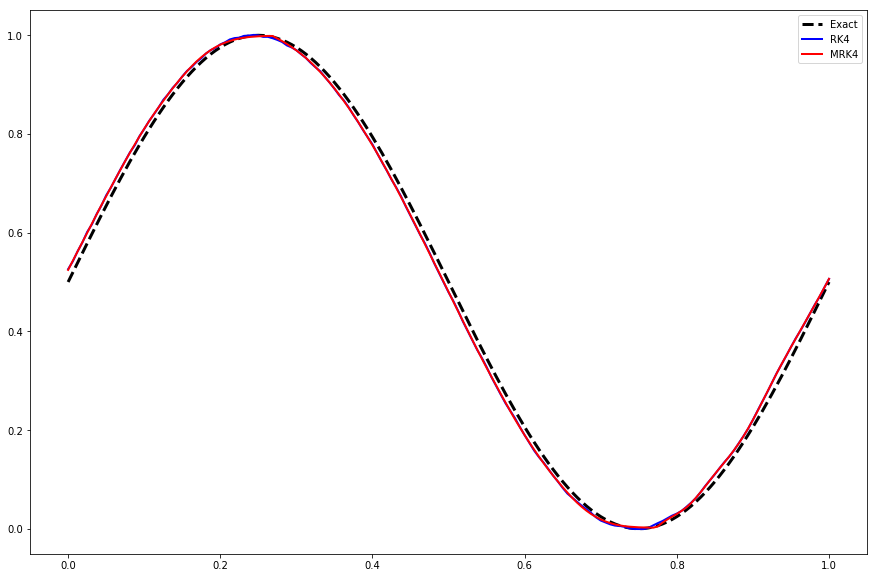

In [10]:
N=161

# physical parameters #
U=1
T=1.0
DT=0.1
x=np.linspace(0,1,N)

# Numerical parameters #
h=1./(N-1);
C=0.8
dt=C*h*U
dt/=1

# Initial conditions #
u0=0.5*(np.sin(2*np.pi*x)+1)
un_RK4=1.0*u0;
un_MRK4=1.0*u0;

(D1,DL)=compute_matrices(U,N)
initial_mass=h*np.sum(u0)

# Time loop #
NT=T/dt
times = np.linspace(0,T,int(NT)+1)
uu_MRK4 = np.zeros([len(u0),int(NT)+1])
uu_RK4 = np.zeros([len(u0),int(NT)+1])
i=0
mmin_Lij=1.0e10 + np.zeros(int(NT)+1)
for t in times:
    # RK4 without stabilization in space
    f1,_,_,_,_=sdisc(un_RK4,D1,DL)
    f2,_,_,_,_=sdisc(un_RK4+0.5*dt*f1,D1,DL)
    f3,_,_,_,_=sdisc(un_RK4+0.5*dt*f2,D1,DL)
    f4,_,_,_,_=sdisc(un_RK4+dt*f3,D1,DL)
    unp1_RK4 = un_RK4 + dt/6.0*(f1+2*f2+2*f3+f4)
        
    # MRK4: stabilization in space with limiters
    f1,f1G,f1B,f1ijG,f1ijB=sdisc(un_MRK4,D1,DL)
    f2,f2G,f2B,f2ijG,f2ijB=sdisc(un_MRK4+0.5*dt*f1,D1,DL)
    f3,f3G,f3B,f3ijG,f3ijB=sdisc(un_MRK4+0.5*dt*f2,D1,DL)
    f4,f4G,f4B,f4ijG,f4ijB=sdisc(un_MRK4+dt*f3,D1,DL)
    fG=f1G # good flux is given by forward Euler 
    
    # conservative RK-FCT #
    fij=(-5*f1ijG+f1ijB + 2*(f2ijG+f2ijB) +2*(f3ijG+f3ijB) + f4ijG+f4ijB)/6.0
    sfB,min_Lij = limited_conservative_flux(un_MRK4,un_MRK4+dt*fG,dt*fij,global_bounds=False)
    mmin_Lij[i] = min(mmin_Lij[i],min_Lij)
    unp1_MRK4 = (un_MRK4 + dt*fG) + sfB
    #
    # update old solution 
    un_RK4 = unp1_RK4
    un_MRK4 = unp1_MRK4

    # save solution  
    uu_RK4[:,i] = unp1_RK4
    uu_MRK4[:,i] = unp1_MRK4

    i+=1
#
loss_RK4 = (initial_mass - h*np.sum(unp1_RK4))/initial_mass
loss_MRK4 = (initial_mass - h*np.sum(unp1_MRK4))/initial_mass

#print('(min, max) value of RK4=',np.min(uu_RK4),np.max(uu_RK4))
#print('(min, max) value of MRK4=',np.min(uu_MRK4),np.max(uu_MRK4))
print('(min, max) value of RK4 at final time t=T=',np.min(unp1_RK4),np.max(unp1_RK4))
print('(min, max) value of MRK4 at final time t=T=',np.min(unp1_MRK4),np.max(unp1_MRK4))

print('loss in mass of (RK4, MRK4)=',loss_RK4,loss_MRK4)
print ('min Lij=', mmin_Lij.min())

print ("L1 error with RK4: \t", h*np.sum(np.abs(unp1_RK4-u0))/np.sum(np.abs(u0)))
print ("L1 error with MRK4: \t", h*np.sum(np.abs(unp1_MRK4-u0))/np.sum(np.abs(u0)))

# plot final solutions #
plt.figure(figsize=([15,10])) 
plt.plot(x,u0,'--k',linewidth=3)
plt.plot(x,unp1_RK4,'-b',linewidth=2)
plt.plot(x,unp1_MRK4,'-r',linewidth=2)
plt.legend(['Exact','RK4','MRK4'])
plt.show()